In [9]:
import numpy as np 
from scipy.io import loadmat
import os
from os.path import join as opj
from h5py import File
import pandas as pd

# load CLIP from huggingface, load the first N images and extract the features
from transformers import CLIPProcessor, CLIPModel
import torch
import tqdm
from PIL import Image

In [10]:
base_path ="/home/matteo/storage/THINGS_Monkey"
monkey = "F"
os.listdir(base_path)

['THINGS_normMUA_F.mat',
 'THINGS_normMUA_N.mat',
 'THINGS_MUA_trials_N.mat',
 'THINGS_MUA_trials_F.mat',
 'THINGS_normMUA.mat',
 'things_imgs_F.mat']

In [11]:
things_imgs = File(opj(base_path,f'things_imgs_{monkey}.mat'))
train_imgs = things_imgs['train_imgs']   # group object --> <HDF5 group "/train_imgs" (3 members)>
test_imgs = things_imgs['test_imgs']


In [12]:
def resolve_reference(hdf5_file, ref):
    """
    Resolve an HDF5 dataset reference and convert it into a string.
    """
    data = hdf5_file[ref][:]
    return ''.join(chr(i) for i in data.flatten() if i > 0)

In [13]:
train_classes = []
train_local_paths = []
train_things_paths = []

test_classes = []
test_local_paths = []
test_things_paths = []

with File(opj(base_path, f"things_imgs_{monkey}.mat")) as f:
    train_imgs = f['train_imgs']
    
    train_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['class']]
    train_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['local_path']]
    train_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['train_imgs']['things_path']]

    test_classes = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['class']]
    test_local_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['local_path']]
    test_things_paths = [resolve_reference(things_imgs, ref[0]) for ref in things_imgs['test_imgs']['things_path']]

In [14]:
trials = File(opj(base_path, f"THINGS_MUA_trials_{monkey}.mat"))
df =pd.DataFrame(trials["ALLMAT"][:].T, columns=["#trial_idx", "#train_idx", "#test_idx", "#rep", "#count", "#correct"])

df

,#trial_idx,#train_idx,#test_idx,#rep,#count,#correct
0,1.0,16504.0,0.0,1.0,1.0,1.0
1,2.0,16470.0,0.0,1.0,2.0,1.0
2,3.0,15094.0,0.0,1.0,3.0,1.0
3,4.0,2514.0,0.0,1.0,4.0,1.0
4,5.0,4860.0,0.0,1.0,1.0,1.0
...,...,...,...,...,...,...
25243,25244.0,0.0,40.0,30.0,1.0,4.0
25244,25245.0,13906.0,0.0,1.0,2.0,4.0
25245,25246.0,470.0,0.0,1.0,3.0,4.0
25246,25247.0,15559.0,0.0,1.0,4.0,4.0


In [15]:
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/trials_allmua.npy', data)
data = np.load('/srv/nfs-data/sisko/matteoc/monkeys/trials_allmua.npy')

print(data.shape)

(300, 25248, 1024)


## Extract Images

In [16]:
thing_base_path = "/home/matteo/storage/THINGS_img/"
N = 15000      # TODO: prenderli tutti (dati training)

train_indices = df[df["#train_idx"]!=0]["#train_idx"].values.astype(int) - 1
test_indices = df[df["#test_idx"]!=0]["#test_idx"].values.astype(int) - 1

sorted_train_img_path = [train_things_paths[i] for i in train_indices]
sorted_test_img_path = [test_things_paths[i] for i in test_indices]

In [17]:
# device = "cuda:3" if torch.cuda.is_available() else "cpu"

# model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
# processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# def extract_features(model, images):
#     images = [Image.open(img).convert("RGB") for img in images]
#     inputs = processor(images= images, return_tensors="pt", padding=True)
#     inputs = {k: v.to(device) for k, v in inputs.items()}
#     with torch.no_grad():
#         outputs = model.get_image_features(**inputs)
#     return outputs

# batch = 256
# train_features = []
# test_features = []

# for i in tqdm.trange(0, N, batch):
#     features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_train_img_path[i:i+batch]])
#     train_features.append(features.cpu().numpy())

# for i in tqdm.trange(0, len(sorted_test_img_path), batch):
#     features = extract_features(model, [opj(thing_base_path,"THINGS","Images", img).replace("\\","/") for img in sorted_test_img_path[i:i+batch]])
#     test_features.append(features.cpu().numpy())

# train_features = np.concatenate(train_features, axis=0)[:N]
# test_features = np.concatenate(test_features, axis=0)


In [18]:
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/train_features.npy', train_features)
# np.save('/srv/nfs-data/sisko/matteoc/monkeys/test_features.npy', test_features)

train_features = np.load('/srv/nfs-data/sisko/matteoc/monkeys/train_features.npy')
test_features = np.load('/srv/nfs-data/sisko/matteoc/monkeys/test_features.npy')

In [19]:
train_features.shape, test_features.shape

((15000, 512), (3000, 512))

In [20]:
neural_train_trial_idx = df[df["#train_idx"]!=0]["#trial_idx"].values.astype(int) - 1
neural_test_trial_idx = df[df["#test_idx"]!=0]["#trial_idx"].values.astype(int) - 1

train_neural = data[:,neural_train_trial_idx[:N]]      # prendo tutte le osservazioni --> no data[:,neural_train_trial_idx[:N]]     
test_neural = data[:,neural_test_trial_idx]
print(train_neural.shape, test_neural.shape)     # SHAPE: num_timepoints, observation, electrodes

(300, 15000, 1024) (300, 3000, 1024)


## Avg activity over repetitions

In [22]:
test_neural_avg = []
test_features_avg = []
selected_test_imgs = []
for idx in tqdm.tqdm(np.unique(test_indices)):
    test_neural_avg.append(test_neural[:,test_indices==idx].mean(1))
    #same for the test features
    test_features_avg.append(test_features[test_indices==idx].mean(0))
    selected_test_imgs.append(np.array(sorted_test_img_path)[test_indices==idx][0])

test_neural_avg = np.array(test_neural_avg).transpose(1,0,-1)
test_features_avg = np.array(test_features_avg)
selected_test_imgs = np.array(selected_test_imgs)

print(test_neural_avg.shape, test_features_avg.shape, selected_test_imgs.shape)

100%|██████████| 100/100 [00:01<00:00, 82.61it/s]

(300, 100, 1024) (100, 512) (100,)


In [23]:
test_neural_avg.shape, test_features_avg.shape, train_features.shape, train_neural.shape     # TODO: primi 100 di prestimolo

((300, 100, 1024), (100, 512), (15000, 512), (300, 15000, 1024))

## Time Neural Network

In [24]:
train_neural = train_neural[100:]  # (200, 15000, 1024)
test_neural_avg = test_neural_avg[100:]  # (200, 100, 1024)

In [259]:
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
    

class TemporalNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, hidden_dim=768, output_dim=512, num_layers=1, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()

        self.rnn = nn.GRU(input_dim, hidden_dim, num_layers=num_layers,
                          batch_first=True, bidirectional=False)
        self.mlp = nn.Sequential(
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):
        rnn_out, _ = self.rnn(x)  # rnn_out: (batch, time, hidden)
        final_hidden = rnn_out[:, -1, :]  
        # final_hidden = torch.mean(rnn_out, dim=1)
        return self.mlp(final_hidden)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
    

class SimpleTCN(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-4, tau=0.05):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, 128, 5, padding=2),
            nn.ReLU(),
            nn.Conv1d(128, 128, 5, padding=2),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.mlp = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        self.loss_fn = nn.MSELoss()
        self.lr = lr
        self.tau = tau

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def forward(self, x):
        x = x.transpose(1, 2)  # (batch, 1024, 200)
        x = self.conv(x).squeeze(-1)  # (batch, 128)
        return self.mlp(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)
    




In [ ]:
import torch
import torch.nn as nn
import pytorch_lightning as pl

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        pos = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(pos * div_term)
        pe[:, 1::2] = torch.cos(pos * div_term)
        self.pe = pe.unsqueeze(0)  # (1, max_len, d_model)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :].to(x.device)
        return x
    

class TransformerNeuralToFeature(pl.LightningModule):
    def __init__(self, input_dim=1024, d_model=256, nhead=8, num_layers=4, output_dim=512, lr=1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        self.d_model = d_model
        self.input_proj = nn.Linear(input_dim, self.d_model)
        self.pos_encoding = PositionalEncoding(self.d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.pooling = nn.AdaptiveAvgPool1d(1)  # mean pooling across time
        self.mlp = nn.Sequential(
            nn.Linear(self.d_model, output_dim),
            nn.ReLU(),
            nn.Linear(output_dim, output_dim)
        )
        self.loss_fn = nn.MSELoss()

    def forward(self, x):  # x: (batch, time, channels)
        x = self.input_proj(x)         # → (batch, time, d_model)
        x = self.pos_encoding(x)       # + positional encodings
        x = self.transformer(x).reshape(x.shape[0], self.d_model, -1)       # → (batch, d_model, time)
        x = self.pooling(x).squeeze(-1)              # mean pooling across time
        return self.mlp(x)             # → (batch, output_dim)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)



In [ ]:
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split
from sklearn.preprocessing import StandardScaler

batch_size = 256
device = 'cuda:2'
cuda_d = 2
seed = 42

X_train = train_neural.transpose(1, 0, 2)  # shape: (15000, 200, 1024)
Y_train = train_features  
X_test = test_neural_avg.transpose(1, 0, 2)  # shape: (15000, 200, 1024)
Y_test = test_features_avg 

scaler_X = StandardScaler()
# X_reshaped = X_train.reshape(-1, X_train.shape[-1])  # (15000*200, 1024)
X_reshaped = X_train.reshape(X_train.shape[0], -1)
X_scaled = scaler_X.fit_transform(X_reshaped)
X_train_tensor = torch.tensor(X_scaled.reshape(15000, 200, 1024), dtype=torch.float32, device=device)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1) 
X_test_scaled = scaler_X.fit_transform(X_test_reshaped)
X_test_tensor = torch.tensor(X_test_scaled.reshape(100, 200, 1024), dtype=torch.float32, device=device)

dataset = TensorDataset(X_train_tensor, torch.tensor(Y_train, dtype=torch.float32, device=device))
test_dataset = TensorDataset(X_test_tensor, torch.tensor(Y_test, dtype=torch.float32, device=device))
val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size
generator1 = torch.Generator().manual_seed(seed)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator1)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [681]:
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import EarlyStopping
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import geomloss 


class SoftMapping(pl.LightningModule):
    def __init__(self, input_dim=1024, output_dim=512, lr=1e-3, tau=0.05):
        super().__init__()

        # self.attn_linear = nn.Linear(input_dim, 1)
        self.attn_linear = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, output_dim)
        )
        self.loss_mse = nn.MSELoss()
        self.lr = lr
        self.tau = tau
        self.log_tau = nn.Parameter(torch.tensor(np.log(tau), dtype=torch.float32))

    def forward(self, x):
        # attn_weights = torch.softmax(self.attn_linear(x), dim=1)
        attn_weights = torch.sigmoid(self.attn_linear(x))
        attn_out = torch.sum(attn_weights * x, dim=1)
        # x_mean = x.mean(dim=1)  # (batch, 1024)
        output = self.mlp(attn_out)
        return output

    def cosine_similarity_matrix(self, A, B):
        A_norm = F.normalize(A, dim=1)
        B_norm = F.normalize(B, dim=1)
        return torch.mm(A_norm, B_norm.T)

    def contrastive_loss_nt(self, S, tau):
        tau = torch.exp(self.log_tau)  
        S_exp = torch.exp(S / tau)
        loss = -torch.log(torch.diag(S_exp) / S_exp.sum(dim=1))
        return loss.mean()

    def training_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_fn(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True)
        self.log("tau", torch.exp(self.log_tau).item(), prog_bar=True)  
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        # loss = self.loss_cl(self(x), y)
        cos_matrix = self.cosine_similarity_matrix(self(x), y)
        loss = self.contrastive_loss_nt(cos_matrix, self.tau)
        self.log("val_loss", loss, on_epoch=True, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-4)

pl.seed_everything(seed, workers=True)
# model = SimpleTCN()
# model = TemporalNeuralToFeature()
model = SoftMapping()
# model = TransformerNeuralToFeature()
logger = CSVLogger("/home/matteoc/nlinear-monkeys/logs/", name="my_model")
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.10, patience=5, verbose=True, mode="min")
trainer = Trainer(max_epochs=35, devices=[cuda_d], logger=logger)  # Usa GPU se disponibile, 35 epoche per il SoftMapping
trainer.fit(model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name         | Type       | Params
--------------------------------------------
0 | attn_linear  | Sequential | 262 K 
1 | mlp          | Sequential | 524 K 
2 | loss_mse     | MSELoss    | 0     
  | other params | n/a        | 1     
--------------------------------------------
787 K     Trainable params
0         Non-trainable params
787 K     Total params
3.150     Total estimated model params size (MB)


Epoch 34: 100%|██████████| 47/47 [00:00<00:00, 95.47it/s, v_num=112, train_loss_step=0.0339, tau=0.0184, val_loss=3.320, train_loss_epoch=0.0367] 

`Trainer.fit` stopped: `max_epochs=35` reached.


Epoch 34: 100%|██████████| 47/47 [00:00<00:00, 85.90it/s, v_num=112, train_loss_step=0.0339, tau=0.0184, val_loss=3.320, train_loss_epoch=0.0367]


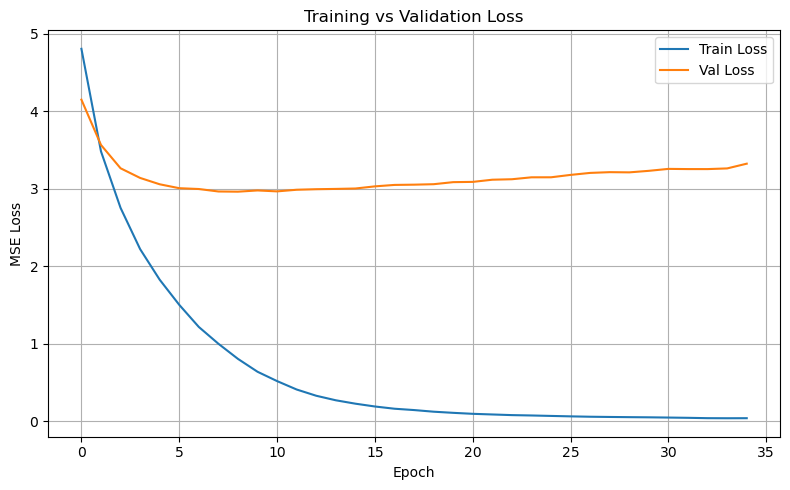

In [682]:
import pandas as pd
import matplotlib.pyplot as plt

log_path = logger.log_dir + "/metrics.csv"
df = pd.read_csv(log_path)

val_loss_df = df[~df["val_loss"].isna()]
train_loss_df = df[~df["train_loss_epoch"].isna()]
plt.figure(figsize=(8, 5))
plt.plot(np.array(train_loss_df["epoch"]), np.array(train_loss_df["train_loss_epoch"]), label="Train Loss")
plt.plot(np.array(val_loss_df["epoch"]), np.array(val_loss_df["val_loss"]), label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [683]:
x,y=next(iter(test_loader))

y_pred=[]
y_true=[]
with torch.no_grad():
    for x,y in tqdm.tqdm(test_loader):
        model = model.to(device)
        y_hat=model(x)
        y_true.append(y)
        y_pred.append(y_hat)
y_pred=torch.cat(y_pred,0)
y_true=torch.cat(y_true,0)




100%|██████████| 1/1 [00:00<00:00, 83.69it/s]


In [684]:
y_pred.shape, y_true.shape

(torch.Size([100, 512]), torch.Size([100, 512]))

In [685]:
y_pred.mean(), y_true.mean(), y_pred.std(), y_true.std()

(tensor(0.0675, device='cuda:2'),
 tensor(-0.0090, device='cuda:2'),
 tensor(10.3525, device='cuda:2'),
 tensor(0.4756, device='cuda:2'))

In [686]:
from sklearn.neighbors import NearestNeighbors

y_true_np = y_true.cpu().numpy()
y_pred_np = y_pred.cpu().numpy()
nbrs = NearestNeighbors(n_neighbors=5, metric='cosine').fit(y_true_np)

distances, top_indices = nbrs.kneighbors(y_pred_np)
true_indices = torch.arange(len(y_true_np)).cpu().numpy()

top1_count = (top_indices[:, 0] == true_indices).sum()
top3_count = sum(true_idx in top_indices[i] for i, true_idx in enumerate(true_indices))

print(f"Top-1 accuracy: {top1_count}/{len(y_true_np)} ({top1_count / len(y_true_np) * 100:.2f}%)")
print(f"Top-3 accuracy: {top3_count}/{len(y_true_np)} ({top3_count / len(y_true_np) * 100:.2f}%)")

Top-1 accuracy: 68/100 (68.00%)
Top-3 accuracy: 90/100 (90.00%)


In [687]:
# SoftMapping(
#   (attn_linear): Sequential(
#     (0): Linear(in_features=1024, out_features=256, bias=True)
#     (1): ReLU()
#     (2): Dropout(p=0.5, inplace=False)
#     (3): Linear(in_features=256, out_features=1, bias=True)
#   )
#   (mlp): Sequential(
#     (0): Linear(in_features=1024, out_features=512, bias=True)
#   )
#   (contrastive_loss): Learnable Tau
# )


# Top-1 accuracy: 68/100 (68.00%)
# Top-3 accuracy: 90/100 (90.00%)